In [29]:
!pip install --upgrade pandas pyarrow
!pip install skforecast

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Lee el archivo .gzip que contiene el parquet directamente
df = pd.read_parquet('bermejales.gzip')

# Muestra las primeras filas de la tabla para verificar
print(df.head())

              datetime         co      no2      o3  pm10     tmp      vv
0  2005-01-01 00:00:00  2269.0000  18.6667  2.5000   NaN  6.0000  0.3333
1  2005-01-01 01:00:00  2269.0000  18.6667  2.5000   NaN  6.0000  0.3333
2  2005-01-01 02:00:00  2024.6667  26.6667  7.5000   NaN  6.6667  1.0000
3  2005-01-01 03:00:00  2229.3333  19.6667  5.5000   NaN  6.1667  0.3333
4  2005-01-01 04:00:00  2096.1667  19.5000  4.6667   NaN  5.3333  0.8333


## VARIABLES

### Contaminantes:

**NO2: (Dióxido de nitrógeno)**:
- Origen principal: Tráfico rodado y combustión (vehículos, calefacción, industria).
- Más alto en horas punta (7–9h, 18–20h) por tráfico.
- Más bajo por la noche y fines de semana.
- Relaciones:
    - Temperatura: tiende a disminuir cuando la temperatura sube, porque hay más mezcla del aire (dispersión vertical).

    - Viento (vv): el viento dispersa los contaminantes → a más viento, menos NO₂.

    - PM₁₀: correlación positiva, porque ambos suelen tener origen en el tráfico.

    - O₃: anticorrelación — el ozono se forma cuando los óxidos de nitrógeno (NOx) reaccionan con luz solar; si hay mucho NO₂, se “consume” ozono. Los picos de NO2 coinciden con los mínimos de O3.

**O3 (Ozono troposférico)**:

- No se emite directamente, se forma fotoquímicamente a partir de NO₂ + compuestos orgánicos volátiles bajo radiación solar.

- Mínimos de noche (sin luz solar).

- Máximos a mediodía y por la tarde (más radiación UV).

- Más alto en verano, más bajo en invierno.

- Relaciones:

    - Temperatura: más calor = más radiación y reacciones fotoquímicas → más O₃.

    - NO₂: relación inversa (NO consume O₃).

    - Viento: el viento puede diluir O₃ localmente, aunque también puede transportarlo desde otras zonas rurales.

    - PM₁₀: a veces correlaciona en verano (ambos altos por condiciones estables).

**PM10 (Material particulado ≤10 μm)**:

- Origen: tráfico (frenado, desgaste), polvo en suspensión, calefacción, industria.

- Relaciones:

    - Viento: suele disminuir con viento fuerte (dispersión), pero si el viento viene de zonas áridas puede aumentarlo (polvo sahariano).

    - Temperatura: en días fríos con inversión térmica, el aire se estratifica → aumenta PM₁₀ (no se dispersa).

    - NO₂: suelen correlacionar (ambos del tráfico).

    - O₃: a veces correlación positiva en verano (ambos asociados a alta radiación y estabilidad atmosférica).


### Variables adicionales:

**Temperatura (tmp)**:

- Relaciones típicas:

    - Con NO₂ y PM₁₀ en invierno → más calor → más dispersión → menos contaminantes.

    - Con O₃ → más calor → más formación fotoquímica.

    - A menudo se ve que los contaminantes primarios bajan con la temperatura, mientras que los secundarios (como O₃) suben.

**Viento (vv)**:
- Efecto general: dispersa contaminantes → reduce concentraciones locales.
- Relaciones:
    - Disminuye las concentraciones de NO₂ y PM₁₀.

    - Puede aumentar la de O₃ si el viento proviene de zonas donde se genera.

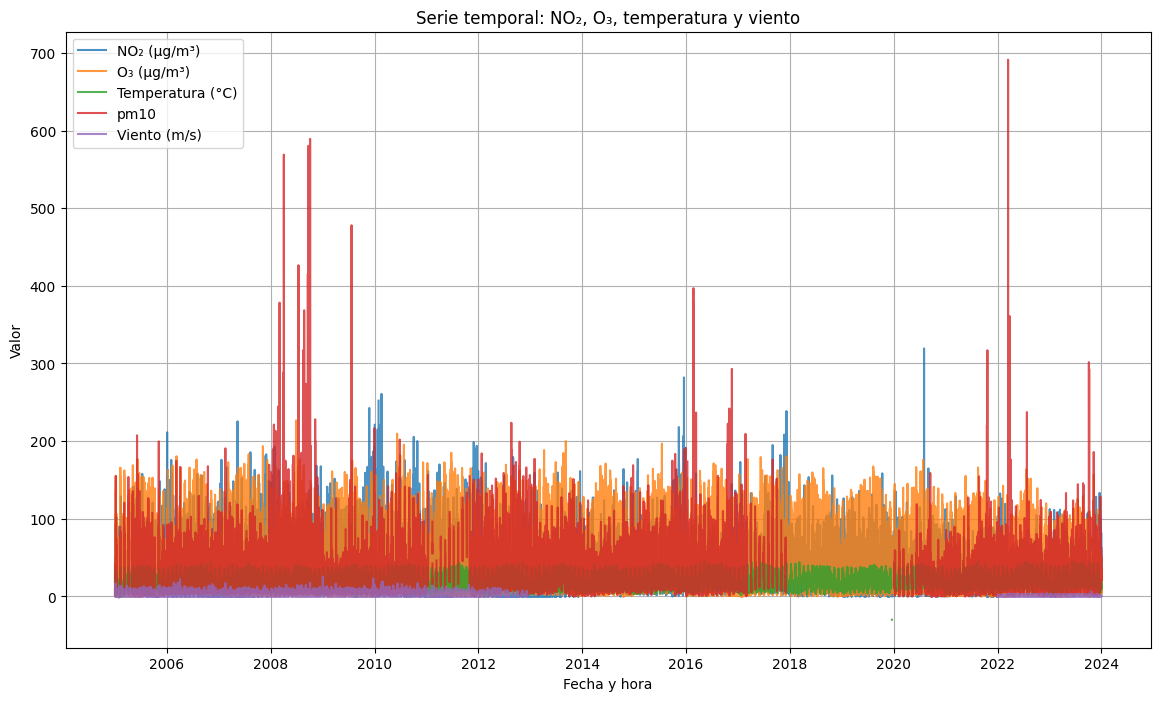

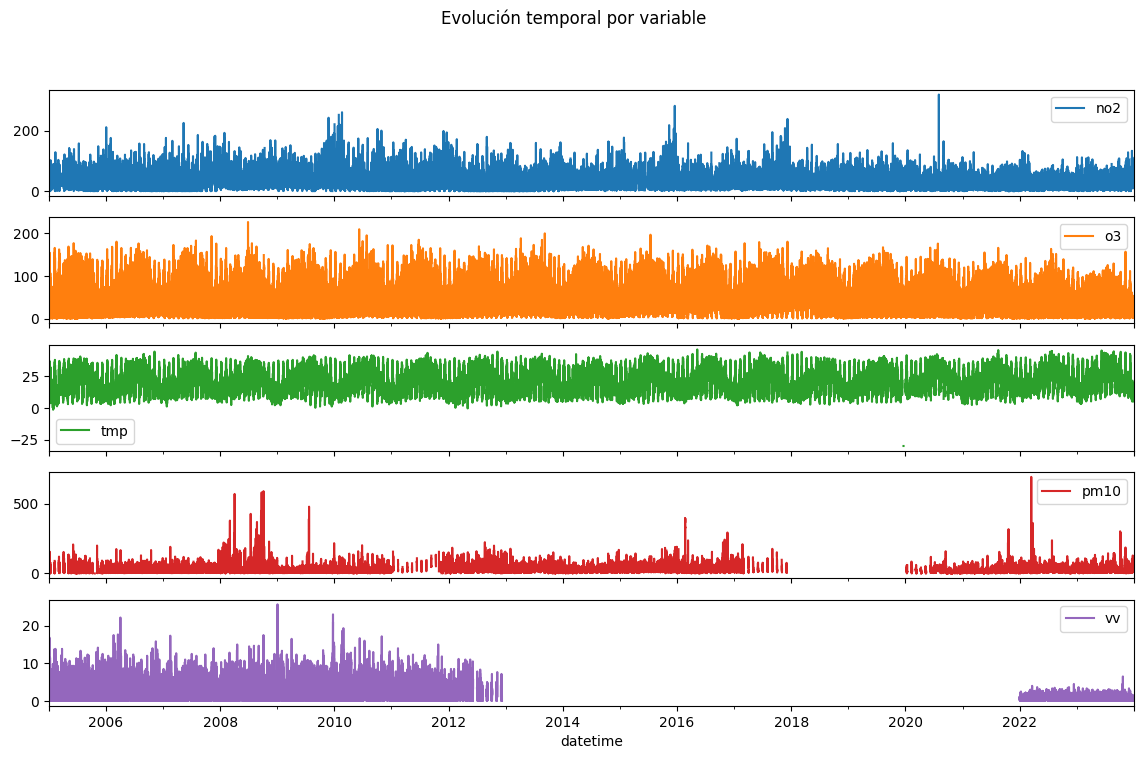

In [2]:
# --- 2. Convertir la columna datetime a tipo fecha ---
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# --- 3. Definir columna temporal como índice ---
df = df.set_index('datetime')

# --- 4. Visualización general ---
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df.index, df['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df.index, df['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df.index, df['pm10'], label='pm10', alpha=0.8)
plt.plot(df.index, df['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal: NO₂, O₃, temperatura y viento')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

# --- 5. Subgráficos por variable ---
variables = ['no2', 'o3', 'tmp','pm10', 'vv']
df[variables].plot(subplots=True, figsize=(14, 8), sharex=True, title='Evolución temporal por variable')
plt.show()


Mostrando datos desde 2023-12-24 hasta 2023-12-31


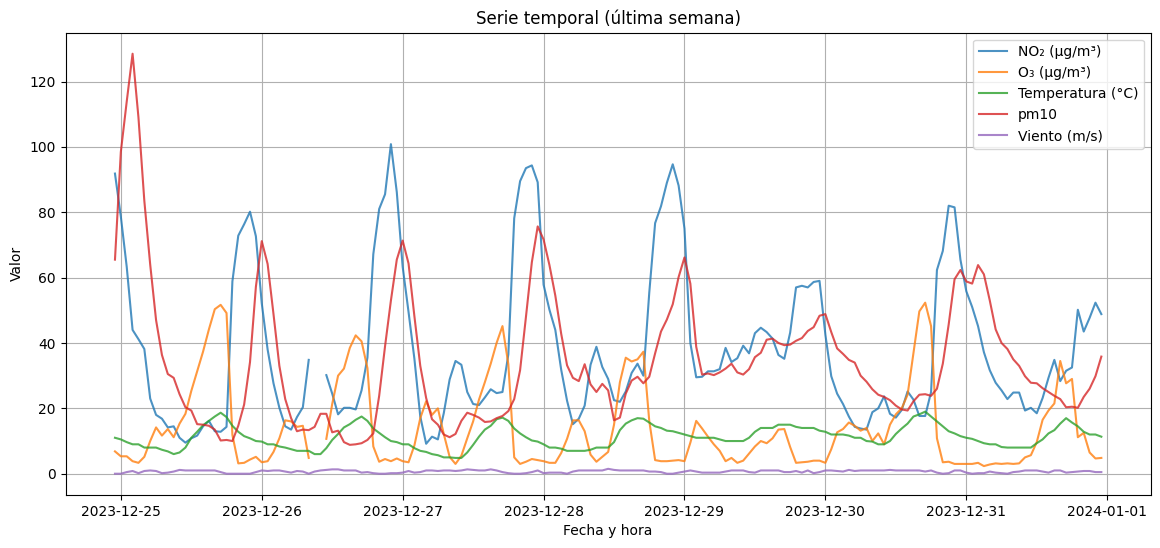

In [3]:
ultima_fecha = df.index.max()
inicio_semana = ultima_fecha - pd.Timedelta(days=7)
df_semana = df.loc[inicio_semana:ultima_fecha]

print(f"Mostrando datos desde {inicio_semana.date()} hasta {ultima_fecha.date()}")

# --- 🔹 Graficar las variables principales ---
plt.figure(figsize=(14, 6))
plt.plot(df_semana.index, df_semana['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_semana.index, df_semana['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_semana.index, df_semana['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_semana.index, df_semana['pm10'], label='pm10', alpha=0.8)
plt.plot(df_semana.index, df_semana['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal (última semana)')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
df

,co,no2,o3,pm10,tmp,vv
datetime,,,,,,
2005-01-01 00:00:00,2269.0000,18.6667,2.5000,NaN,6.0000,0.3333
2005-01-01 01:00:00,2269.0000,18.6667,2.5000,NaN,6.0000,0.3333
2005-01-01 02:00:00,2024.6667,26.6667,7.5000,NaN,6.6667,1.0000
2005-01-01 03:00:00,2229.3333,19.6667,5.5000,NaN,6.1667,0.3333
2005-01-01 04:00:00,2096.1667,19.5000,4.6667,NaN,5.3333,0.8333
...,...,...,...,...,...,...
2023-12-31 19:00:00,716.8333,50.1667,11.1667,20.1667,14.5000,0.6667
2023-12-31 20:00:00,678.6667,43.5000,12.5000,23.5000,12.8333,0.8333
2023-12-31 21:00:00,758.8333,47.6667,6.5000,26.0000,12.0000,0.8333


In [5]:
ultima_fecha = df.index.max()
inicio_semana = ultima_fecha - pd.Timedelta(days=365)
df_year = df.loc[inicio_semana:ultima_fecha]

In [6]:
df_year.isna().sum()

co       80
no2     245
o3       63
pm10     56
tmp       1
vv        1
dtype: int64

### 2005 a 2010

In [7]:


df_4 = df.truncate(before = '2006-01-01 00:00:00', after= '2010-12-31 23:00:00')

In [8]:
df_4

,co,no2,o3,pm10,tmp,vv
datetime,,,,,,
2006-01-01 00:00:00,183.0000,9.0000,48.1667,4.6667,13.0000,1.3333
2006-01-01 01:00:00,191.1667,7.8333,51.6667,5.0000,13.0000,2.6667
2006-01-01 02:00:00,204.0000,12.8333,48.6667,9.6667,13.0000,3.3333
2006-01-01 03:00:00,243.0000,9.8333,49.0000,11.5000,13.0000,2.3333
2006-01-01 04:00:00,252.8333,10.5000,44.6667,7.6667,12.5000,1.0000
...,...,...,...,...,...,...
2010-12-31 19:00:00,416.5000,12.0000,62.8333,9.8333,16.0000,3.5000
2010-12-31 20:00:00,460.3333,25.3333,48.5000,8.8333,15.6667,3.5000
2010-12-31 21:00:00,432.0000,34.6667,43.1667,7.3333,15.0000,3.1667


In [9]:
df_4.isna().sum(), df_4.shape

(co      2401
 no2     3041
 o3      1701
 pm10    2803
 tmp      722
 vv       789
 dtype: int64,
 (43824, 6))

In [10]:
# 1.3 comprobar frecuencia y huecos
print("Frecuencia inferida:", pd.infer_freq(df_4.index))
# mostrar primeras/últimas filas y huecos
print(df_4.head())
print(df_4.tail())


Frecuencia inferida: h
                           co      no2       o3     pm10   tmp      vv
datetime                                                              
2006-01-01 00:00:00  183.0000   9.0000  48.1667   4.6667  13.0  1.3333
2006-01-01 01:00:00  191.1667   7.8333  51.6667   5.0000  13.0  2.6667
2006-01-01 02:00:00  204.0000  12.8333  48.6667   9.6667  13.0  3.3333
2006-01-01 03:00:00  243.0000   9.8333  49.0000  11.5000  13.0  2.3333
2006-01-01 04:00:00  252.8333  10.5000  44.6667   7.6667  12.5  1.0000
                           co      no2       o3     pm10      tmp      vv
datetime                                                                 
2010-12-31 19:00:00  416.5000  12.0000  62.8333   9.8333  16.0000  3.5000
2010-12-31 20:00:00  460.3333  25.3333  48.5000   8.8333  15.6667  3.5000
2010-12-31 21:00:00  432.0000  34.6667  43.1667   7.3333  15.0000  3.1667
2010-12-31 22:00:00  426.6667  22.8333  51.6667  19.1667  15.0000  2.1667
2010-12-31 23:00:00  398.8333  11.83

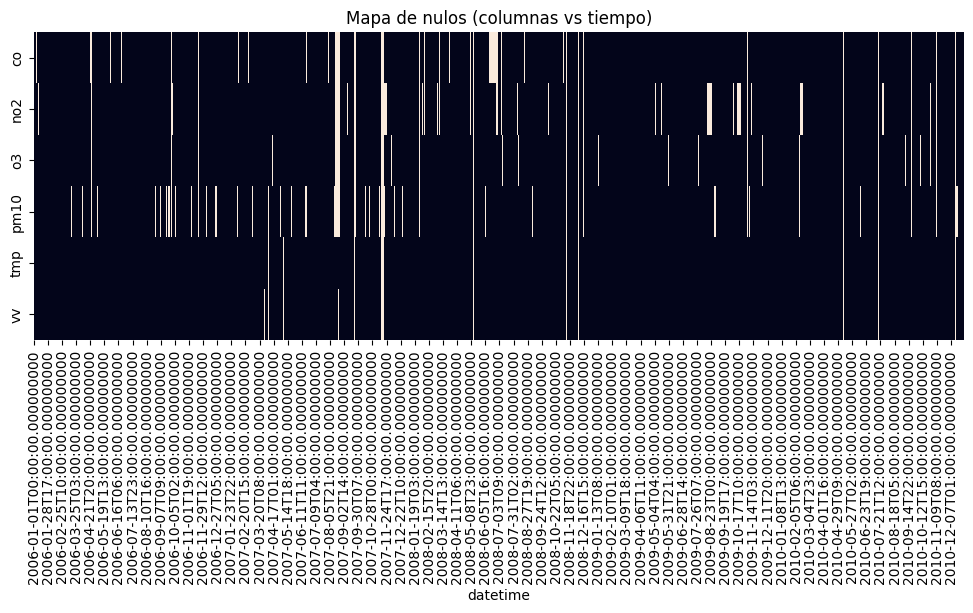

In [11]:
import seaborn as sns
plt.figure(figsize=(12,4))
sns.heatmap(df_4.isna().T, cbar=False)
plt.title('Mapa de nulos (columnas vs tiempo)')
plt.show()

In [12]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# 4.1: Imputación rápida para huecos pequeños con interpolación por columna
df_interp = df_4.copy()
for col in df_interp.columns:
    # interpolación temporal; limit=6 -> no imputa tramos mayores a 6 horas (ajusta)
    df_interp[col] = df_interp[col].interpolate(method='time', limit=6)


print(df_interp.isna().sum())

# 4.2: Para huecos más largos, usar IterativeImputer (e.g. BayesianRidge pred) o KNN
# crear features de tiempo para ayudar a imputar

df_imp = df_interp.copy()
df_imp['hour'] = df_imp.index.hour
df_imp['dayofweek'] = df_imp.index.dayofweek
df_imp['month'] = df_imp.index.month

# Imputador iterativo (puede ser más robusto que KNN)
imp = IterativeImputer(random_state=0, max_iter=10)
cols = ['co','no2','o3','pm10','tmp','vv','hour','dayofweek','month']
imputed = imp.fit_transform(df_imp[cols])
df_imputed = pd.DataFrame(imputed, index=df_imp.index, columns=cols)

# Volver a asignar sólo las variables originales (no los features)

co      1750
no2     2270
o3      1125
pm10    2016
tmp      542
vv       604
dtype: int64


In [13]:
df_imputed.isna().sum()

co           0
no2          0
o3           0
pm10         0
tmp          0
vv           0
hour         0
dayofweek    0
month        0
dtype: int64

### Serie con nulos imputados

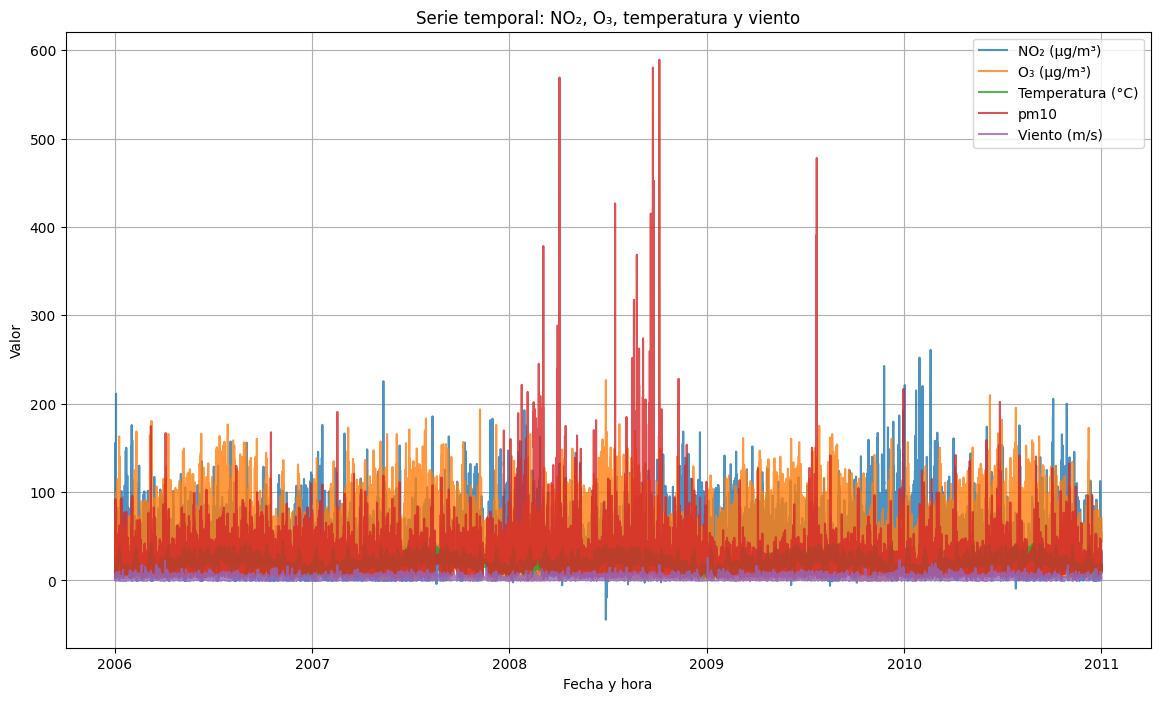

In [14]:
plt.figure(figsize=(14, 8))
plt.plot(df_imputed.index, df_imputed['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['pm10'], label='pm10', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal: NO₂, O₃, temperatura y viento')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

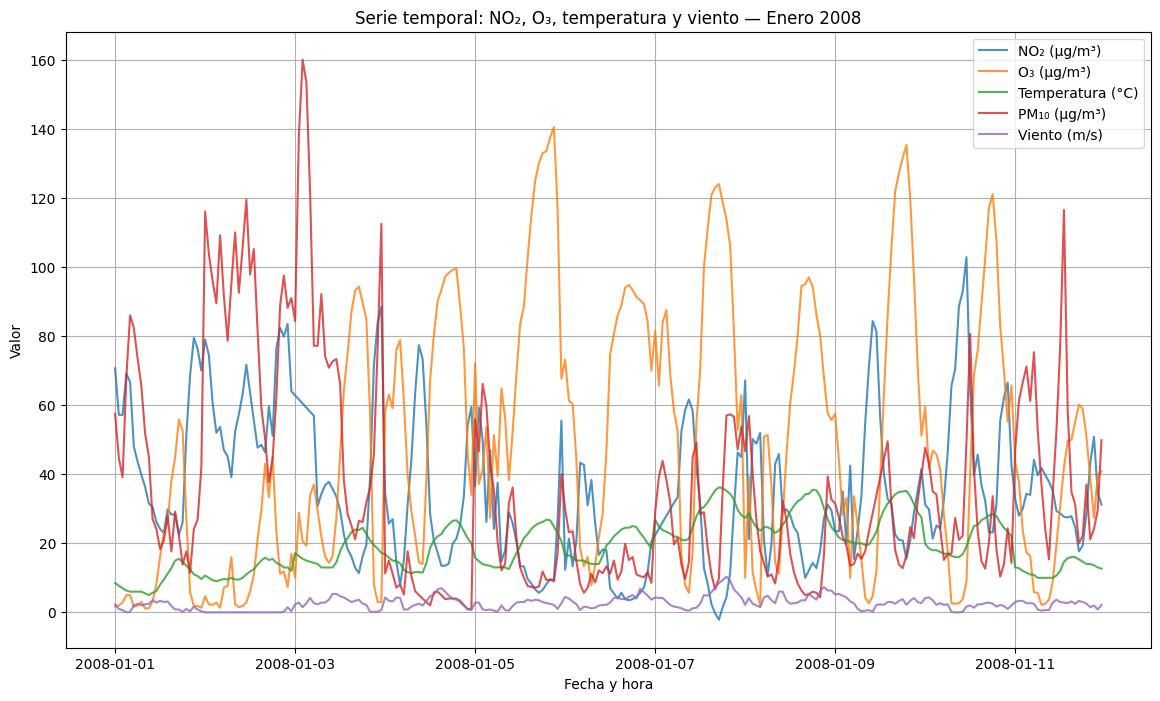

In [15]:
df_mes = df_imputed.loc['2008-01-01':'2008-01-11']

plt.figure(figsize=(14, 8))
plt.plot(df_mes.index, df_mes['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_mes.index, df_mes['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_mes.index, df_mes['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_mes.index, df_mes['pm10'], label='PM₁₀ (µg/m³)', alpha=0.8)
plt.plot(df_mes.index, df_mes['vv'], label='Viento (m/s)', alpha=0.8)

plt.title('Serie temporal: NO₂, O₃, temperatura y viento — Enero 2008')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
def cap_outliers(s, k=1.5):
    q1 = df_imputed[s].quantile(0.25)
    q3 = df_imputed[s].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    outliers = df_imputed[(df_imputed[s] < lower) | (df_imputed[s] > upper)]
    print('Outliers en '+str(s)+ ' ' + str(len(outliers)))

cols_to_check = ['no2', 'pm10', 'tmp', 'vv', 'o3']
for col in cols_to_check:
    cap_outliers(col)


Outliers en no2 1426
Outliers en pm10 2791
Outliers en tmp 129
Outliers en vv 1504
Outliers en o3 113


### NORMALIZACION

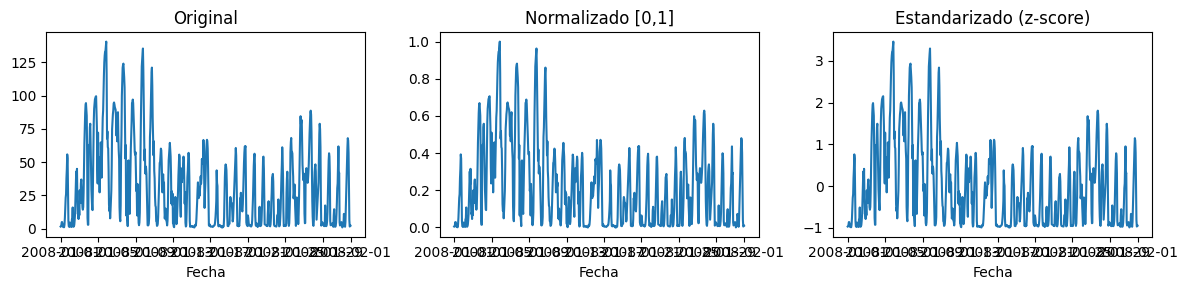

,o3,Nivel_normalizado,Nivel_estandarizado
count,744.000000,744.000000,7.440000e+02
mean,32.096034,0.222911,9.550306e-17
std,31.339865,0.224659,1.000673e+00
min,1.000000,0.000000,-9.928873e-01
25%,3.791650,0.020012,-9.037507e-01
50%,23.083350,0.158304,-2.877724e-01
75%,51.333300,0.360812,6.142403e-01
max,140.500000,1.000000,3.461307e+00


In [17]:
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

df_mes = df_imputed.loc['2008-01-01':'2008-01-31']
# Trabajamos sobre una copia para no tocar 
df = df_mes.copy()
columna = 'o3'   # cambia si tu variable principal tiene otro nombre

# --- Normalización [0,1] ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df['Nivel_normalizado'] = scaler_minmax.fit_transform(df[[columna]])

# --- Estandarización (z-score) ---
scaler_std = StandardScaler()
df['Nivel_estandarizado'] = scaler_std.fit_transform(df[[columna]])

# --- Comparación visual (original vs transformaciones) ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df.index, df[columna]);                 axes[0].set_title('Original')
axes[1].plot(df.index, df['Nivel_normalizado']);     axes[1].set_title('Normalizado [0,1]')
axes[2].plot(df.index, df['Nivel_estandarizado']);   axes[2].set_title('Estandarizado (z-score)')
for ax in axes: ax.set_xlabel('Fecha')
plt.tight_layout(); plt.show()

# --- Comparación numérica rápida ---
display(df[[columna, 'Nivel_normalizado', 'Nivel_estandarizado']].describe())

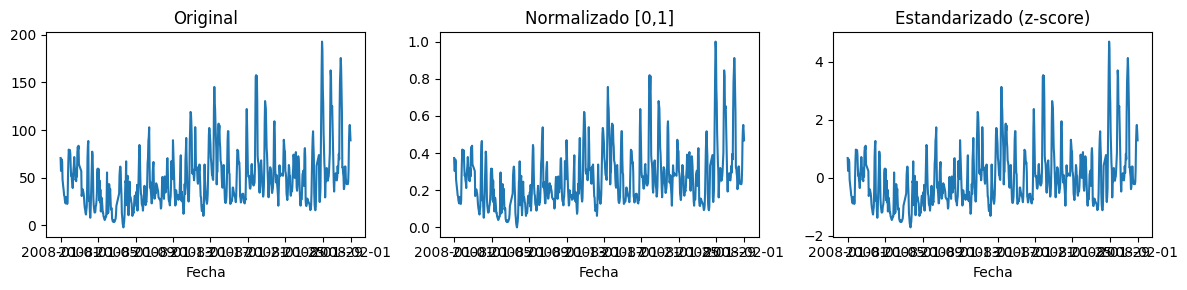

,no2,Nivel_normalizado,Nivel_estandarizado
count,744.000000,744.000000,7.440000e+02
mean,49.814604,0.266655,-2.292073e-16
std,30.428786,0.156209,1.000673e+00
min,-2.128549,0.000000,-1.708188e+00
25%,28.333300,0.156379,-7.064283e-01
50%,44.166700,0.237661,-1.857354e-01
75%,62.705025,0.332829,4.239108e-01
max,192.666700,1.000000,4.697795e+00


In [18]:
columna = 'no2'   # cambia si tu variable principal tiene otro nombre

# --- Normalización [0,1] ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df['Nivel_normalizado'] = scaler_minmax.fit_transform(df[[columna]])

# --- Estandarización (z-score) ---
scaler_std = StandardScaler()
df['Nivel_estandarizado'] = scaler_std.fit_transform(df[[columna]])

# --- Comparación visual (original vs transformaciones) ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df.index, df[columna]);                 axes[0].set_title('Original')
axes[1].plot(df.index, df['Nivel_normalizado']);     axes[1].set_title('Normalizado [0,1]')
axes[2].plot(df.index, df['Nivel_estandarizado']);   axes[2].set_title('Estandarizado (z-score)')
for ax in axes: ax.set_xlabel('Fecha')
plt.tight_layout(); plt.show()

# --- Comparación numérica rápida ---
display(df[[columna, 'Nivel_normalizado', 'Nivel_estandarizado']].describe())

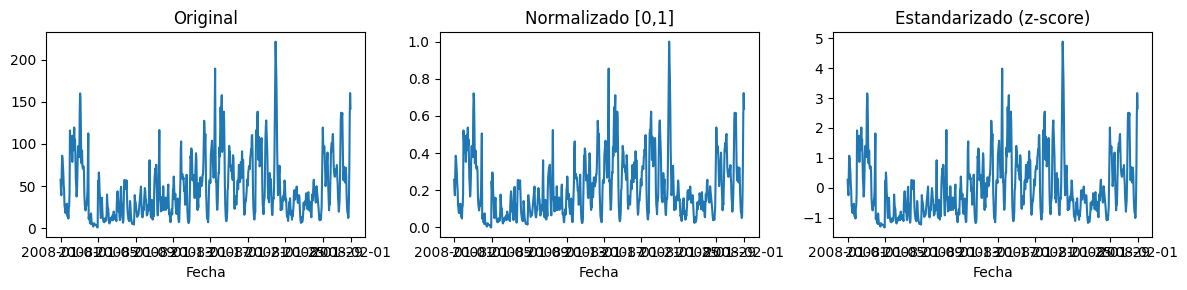

,pm10,Nivel_normalizado,Nivel_estandarizado
count,744.000000,744.000000,7.440000e+02
mean,48.182526,0.214142,-3.820122e-17
std,35.454571,0.160913,1.000673e+00
min,1.000000,0.000000,-1.331683e+00
25%,21.166700,0.091528,-7.624969e-01
50%,39.027783,0.172592,-2.583842e-01
75%,67.333300,0.301059,5.405130e-01
max,221.333300,1.000000,4.887022e+00


In [19]:
columna = 'pm10'   # cambia si tu variable principal tiene otro nombre

# --- Normalización [0,1] ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df['Nivel_normalizado'] = scaler_minmax.fit_transform(df[[columna]])

# --- Estandarización (z-score) ---
scaler_std = StandardScaler()
df['Nivel_estandarizado'] = scaler_std.fit_transform(df[[columna]])

# --- Comparación visual (original vs transformaciones) ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df.index, df[columna]);                 axes[0].set_title('Original')
axes[1].plot(df.index, df['Nivel_normalizado']);     axes[1].set_title('Normalizado [0,1]')
axes[2].plot(df.index, df['Nivel_estandarizado']);   axes[2].set_title('Estandarizado (z-score)')
for ax in axes: ax.set_xlabel('Fecha')
plt.tight_layout(); plt.show()

# --- Comparación numérica rápida ---
display(df[[columna, 'Nivel_normalizado', 'Nivel_estandarizado']].describe())

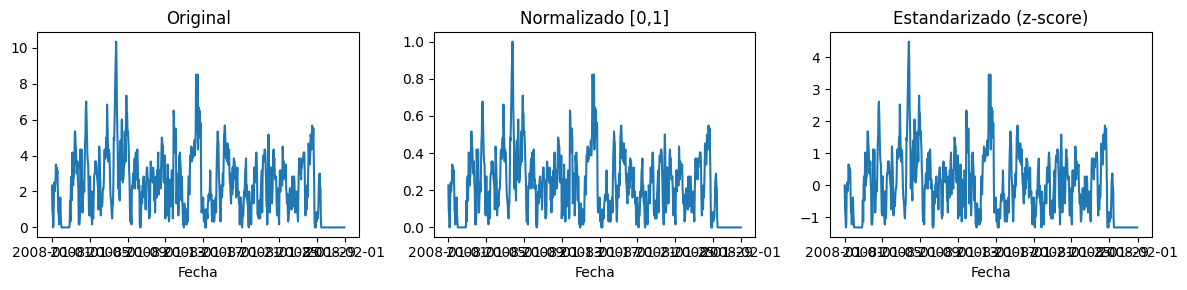

,vv,Nivel_normalizado,Nivel_estandarizado
count,744.000000,744.000000,7.440000e+02
mean,2.346551,0.227086,1.337043e-16
std,1.783418,0.172589,1.000673e+00
min,0.000000,0.000000,-1.316645e+00
25%,0.833300,0.080642,-8.490823e-01
50%,2.166700,0.209681,-1.009140e-01
75%,3.500000,0.338711,6.471982e-01
max,10.333300,1.000000,4.481350e+00


In [20]:
columna = 'vv'   # cambia si tu variable principal tiene otro nombre

# --- Normalización [0,1] ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df['Nivel_normalizado'] = scaler_minmax.fit_transform(df[[columna]])

# --- Estandarización (z-score) ---
scaler_std = StandardScaler()
df['Nivel_estandarizado'] = scaler_std.fit_transform(df[[columna]])

# --- Comparación visual (original vs transformaciones) ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df.index, df[columna]);                 axes[0].set_title('Original')
axes[1].plot(df.index, df['Nivel_normalizado']);     axes[1].set_title('Normalizado [0,1]')
axes[2].plot(df.index, df['Nivel_estandarizado']);   axes[2].set_title('Estandarizado (z-score)')
for ax in axes: ax.set_xlabel('Fecha')
plt.tight_layout(); plt.show()

# --- Comparación numérica rápida ---
display(df[[columna, 'Nivel_normalizado', 'Nivel_estandarizado']].describe())

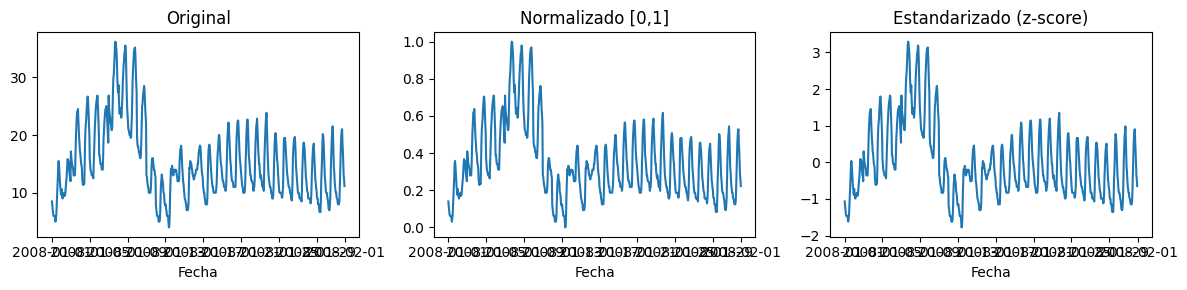

,tmp,Nivel_normalizado,Nivel_estandarizado
count,744.000000,744.000000,7.440000e+02
mean,15.275538,0.350534,2.101067e-16
std,6.345595,0.197272,1.000673e+00
min,4.000000,0.000000,-1.778103e+00
25%,10.666700,0.207255,-7.267937e-01
50%,13.916650,0.308289,-2.142907e-01
75%,18.708350,0.457254,5.413395e-01
max,36.166700,1.000000,3.294445e+00


In [21]:
columna = 'tmp'   # cambia si tu variable principal tiene otro nombre

# --- Normalización [0,1] ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df['Nivel_normalizado'] = scaler_minmax.fit_transform(df[[columna]])

# --- Estandarización (z-score) ---
scaler_std = StandardScaler()
df['Nivel_estandarizado'] = scaler_std.fit_transform(df[[columna]])

# --- Comparación visual (original vs transformaciones) ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df.index, df[columna]);                 axes[0].set_title('Original')
axes[1].plot(df.index, df['Nivel_normalizado']);     axes[1].set_title('Normalizado [0,1]')
axes[2].plot(df.index, df['Nivel_estandarizado']);   axes[2].set_title('Estandarizado (z-score)')
for ax in axes: ax.set_xlabel('Fecha')
plt.tight_layout(); plt.show()

# --- Comparación numérica rápida ---
display(df[[columna, 'Nivel_normalizado', 'Nivel_estandarizado']].describe())

### MODELO BASE AUTOREGRESIVO SIN EXOGENAS:

La variable que queremos predecir es el ozono `O3`

In [36]:
y = df_mes['o3'].astype(float)

In [37]:
y

datetime
2008-01-01 00:00:00     1.6667
2008-01-01 01:00:00     2.0000
2008-01-01 02:00:00     2.8333
2008-01-01 03:00:00     5.0000
2008-01-01 04:00:00     5.0000
                        ...   
2008-01-31 19:00:00    32.6667
2008-01-31 20:00:00     6.5000
2008-01-31 21:00:00     1.6667
2008-01-31 22:00:00     2.1667
2008-01-31 23:00:00     2.3333
Name: o3, Length: 744, dtype: float64

Tamaño: (744,)
Nulos: 0


count    744.000000
mean      32.096034
std       31.339865
min        1.000000
25%        3.791650
50%       23.083350
75%       51.333300
max      140.500000
Name: o3, dtype: float64

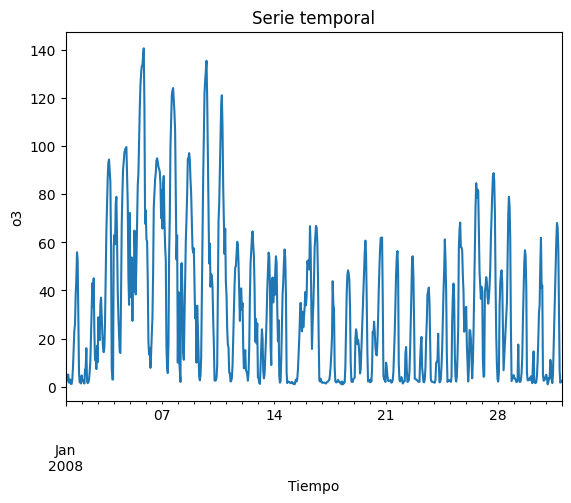

In [38]:
print("Tamaño:", y.shape)
print("Nulos:", int(y.isna().sum()))
display(y.describe())

# Relleno simple si hay nulos
if y.isna().any():
    y = y.interpolate().bfill()

ax = y.plot(title='Serie temporal')
ax.set_xlabel('Tiempo'); ax.set_ylabel('o3')
plt.show()

train:(520,), valid:(112,), test:(112,)


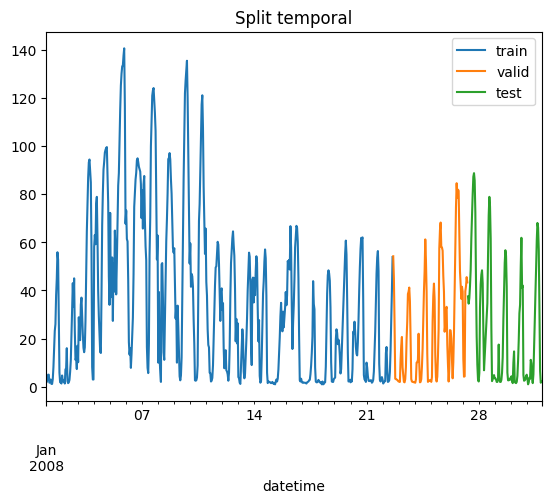

In [39]:
# 5) Split y CV
n = len(y)
train_end = int(0.70*n)
valid_end = int(0.85*n)

y_train = y.iloc[:train_end]
y_valid = y.iloc[train_end:valid_end]
y_test  = y.iloc[valid_end:]

print(f"train:{y_train.shape}, valid:{y_valid.shape}, test:{y_test.shape}")

ax = y_train.plot(label='train')
y_valid.plot(ax=ax, label='valid')
y_test.plot(ax=ax, label='test', title='Split temporal')
ax.legend(); plt.show()


In [56]:
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
# 1) Serie numérica ordenada
y = y.astype(float).sort_index()

# 2) Inferir frecuencia; si existe, regularizar con asfreq
freq = pd.infer_freq(y.index)

# Heurística: si no infiere pero parece semanal (~7 días), fuerza 'W'
if freq is None and len(y) > 2:
    diffs = pd.Series(y.index[1:]).reset_index(drop=True) - pd.Series(y.index[:-1]).reset_index(drop=True)
    try:
        step_days = abs(diffs.median().days)
        if step_days in (6, 7, 8):
            freq = 'W'
    except Exception:
        pass

if freq is not None:
    y = y.asfreq(freq)
if freq is not None:
    y_train.index = pd.DatetimeIndex(y_train.index, freq=freq)
    y_valid.index = pd.DatetimeIndex(y_valid.index, freq=freq)
else:
    print('⚠️ Serie sin frecuencia inferible. Puedes usar ignore_freq=True en fit/backtesting.')


print(f'Freq: {freq}')
print(f'Train: {y_train.index[0].date()} → {y_train.index[-1].date()} (n={len(y_train)})')
print(f'Valid: {y_valid.index[0].date()} → {y_valid.index[-1].date()} (n={len(y_valid)})')

cv = TimeSeriesFold(
    steps=len(y_valid),
    initial_train_size=len(y) - len(y_valid),
    fixed_train_size=True
)
cv

Freq: h
Train: 2008-01-01 → 2008-01-22 (n=520)
Valid: 2008-01-22 → 2008-01-27 (n=112)


============== 
TimeSeriesFold 
============== 
Initial train size    = 632,
Steps                 = 112,
Fold stride           = 112,
Overlapping folds     = False,
Window size           = None,
Differentiation       = None,
Refit                 = False,
Fixed train size      = True,
Gap                   = 0,
Skip folds            = None,
Allow incomplete fold = True,
Return all indexes    = False,
Verbose               = True

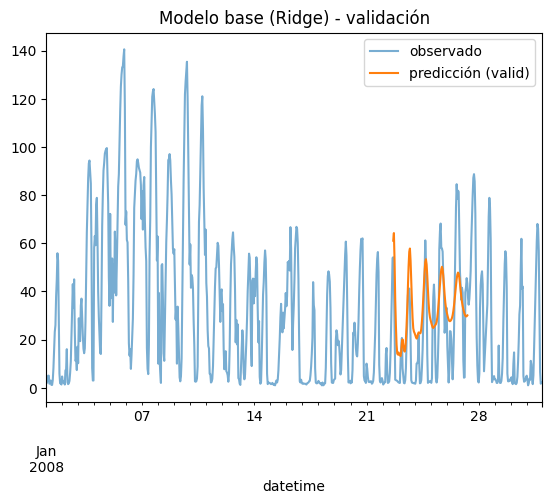

{'MAE': 15.916248895738972, 'RMSE': 18.7759134904271, 'MAPE': np.float64(330.6315940023435)}


In [57]:
from sklearn.linear_model import Ridge
from skforecast.recursive import ForecasterRecursive
import math

lags_base = 36

reg_base = Ridge(alpha=1.0, random_state=0)
forecaster_base = ForecasterRecursive(regressor=reg_base, lags=lags_base)

forecaster_base.fit(y=y_train)

# Pronóstico sobre valid (h = len(valid))
h = len(y_valid)
pred_valid_base = forecaster_base.predict(steps=h)
pred_valid_base.index = y_valid.index

# Visualizar
ax = y.plot(label='observado', alpha=0.6, title='Modelo base (Ridge) - validación')
pred_valid_base.plot(ax=ax, label='predicción (valid)')
ax.legend(); plt.show()

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))*100

mae = mean_absolute_error(y_valid, pred_valid_base)
rmse = math.sqrt(mean_squared_error(y_valid, pred_valid_base))
mape_v = mape(y_valid, pred_valid_base)
print({'MAE': mae, 'RMSE': rmse, 'MAPE': mape_v})

In [58]:
# === Helpers robustos para grid-search y backtesting ===

def tune_model(y, regressor, param_grid, lags_grid, cv, metric='mean_absolute_error', ignore_freq=None):
    """
    Ejecuta grid_search_forecaster() y devuelve SIEMPRE:
      - results_df: DataFrame con combinaciones evaluadas
      - f_best: ForecasterRecursive ajustado con la mejor configuración
    Compatible con variantes que devuelven dict o DataFrame.
    """
    f = ForecasterRecursive(regressor=regressor, lags=lags_grid[0] if len(lags_grid) else 12)
    kwargs = dict(
        forecaster=f, y=y, cv=cv, lags_grid=lags_grid, param_grid=param_grid,
        metric=metric, return_best=True, verbose=False
    )
    if ignore_freq:
        kwargs['ignore_freq'] = True

    out = grid_search_forecaster(**kwargs)

    if isinstance(out, dict) and 'results' in out and 'forecaster' in out:
        results_df, f_best = out['results'], out['forecaster']
    else:
        results_df, f_best = out, f  # algunas versiones devuelven DF y modifican f in-place

    return results_df, f_best


def backtest_best(f_best, y, cv, metric='mean_absolute_error', ignore_freq=None):
    """
    Devuelve:
      - metrics_out: métricas por split (tipo varía por versión)
      - preds_out: DF de predicciones o None
    Soporta API con/sin 'return_predict'.
    """
    kwargs = dict(forecaster=f_best, y=y, cv=cv, metric=metric, verbose=False)
    if ignore_freq:
        kwargs['ignore_freq'] = True

    try:
        metrics_out, preds_out = backtesting_forecaster(return_predict=True, **kwargs)
    except TypeError:
        out = backtesting_forecaster(**kwargs)
        if isinstance(out, tuple) and len(out) == 2:
            metrics_out, preds_out = out
        else:
            metrics_out, preds_out = out, None
    return metrics_out, preds_out


def extract_mae(metrics_out, metric_name='mean_absolute_error'):
    """Extrae un MAE medio de la salida de métricas, sea float/Series/DataFrame."""
    import numpy as _np
    import pandas as _pd
    if isinstance(metrics_out, (float, int, _np.floating, _np.integer)):
        return float(metrics_out)
    if isinstance(metrics_out, _pd.Series):
        return float(_pd.to_numeric(metrics_out, errors='coerce').mean())
    if isinstance(metrics_out, _pd.DataFrame):
        df = metrics_out.copy()
        if {'metric','value'}.issubset(df.columns):
            mask = (df['metric'] == metric_name)
            if mask.any():
                return float(_pd.to_numeric(df.loc[mask, 'value'], errors='coerce').mean())
            return float(_pd.to_numeric(df['value'], errors='coerce').mean())
        if metric_name in df.columns:
            return float(_pd.to_numeric(df[metric_name], errors='coerce').mean())
        if 'value' in df.columns:
            return float(_pd.to_numeric(df['value'], errors='coerce').mean())
        num = df.select_dtypes(include=_np.number)
        if not num.empty:
            return float(num.iloc[:, 0].mean())
    raise ValueError('Formato de métricas no reconocido para extraer MAE.')

In [59]:
# === Rejillas y ejecución de tuning ===

ridge = Ridge(random_state=0)
tree  = DecisionTreeRegressor(random_state=0)
rf    = RandomForestRegressor(random_state=0, n_estimators=200, n_jobs=-1)

lags_grid = [12, 24, 36]
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}
param_grid_tree  = {'max_depth': [3, 5, 8, None]}
param_grid_rf    = {'n_estimators': [200, 400], 'max_depth': [5, 10, None]}

print('🔎 Tuning Ridge...')
ridge_results, f_ridge_best = tune_model(y, ridge, param_grid_ridge, lags_grid, cv)

print('🔎 Tuning Decision Tree...')
tree_results,  f_tree_best  = tune_model(y, tree,  param_grid_tree,  lags_grid, cv)

print('🔎 Tuning Random Forest...')
rf_results,    f_rf_best    = tune_model(y, rf,    param_grid_rf,    lags_grid, cv)

# Vista previa de resultados de Ridge
ridge_results.head()

🔎 Tuning Ridge...


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'alpha': 10.0}
  Backtesting metric: 22.410342517796316
🔎 Tuning Decision Tree...


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 5}
  Backtesting metric: 21.510648130580357
🔎 Tuning Random Forest...


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 22.102274677977327


,lags,lags_label,params,mean_absolute_error,alpha
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 10.0},22.410343,10.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1.0},22.410460,1.0
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},22.410472,0.1
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 10.0},24.475051,10.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 1.0},24.475054,1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Comparación de MAE (promedio CV):


,modelo,mae_cv
1,DecisionTree,21.510648
2,RandomForest,22.102275
0,Ridge,22.410343


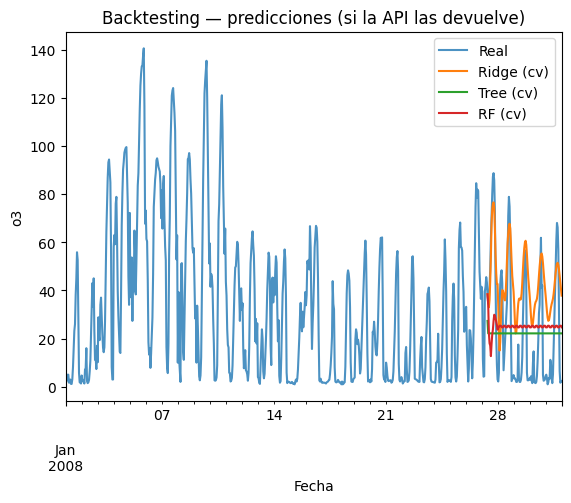

In [61]:
# === Backtesting con los mejores modelos ===

m_ridge, p_ridge = backtest_best(f_ridge_best, y, cv)
m_tree,  p_tree  = backtest_best(f_tree_best,  y, cv)
m_rf,    p_rf    = backtest_best(f_rf_best,    y, cv)

# Comparación de MAE (promedio)
compare = pd.DataFrame({
    'modelo': ['Ridge', 'DecisionTree', 'RandomForest'],
    'mae_cv': [
        extract_mae(m_ridge, 'mean_absolute_error'),
        extract_mae(m_tree,  'mean_absolute_error'),
        extract_mae(m_rf,    'mean_absolute_error'),
    ]
}).sort_values('mae_cv')

print('Comparación de MAE (promedio CV):')
display(compare)

# Intentar graficar predicciones (si existen) del último tramo
def plot_cv_preds(preds, label):
    if preds is None or not isinstance(preds, pd.DataFrame):
        return False
    for col in ['pred', 'prediction', 'y_pred', 'forecast']:
        if col in preds.columns:
            preds[col].plot(label=label)
            return True
    return False

plt.figure()
y.plot(label='Real', alpha=0.8)
ok = False
ok |= plot_cv_preds(p_ridge, 'Ridge (cv)')
ok |= plot_cv_preds(p_tree,  'Tree (cv)')
ok |= plot_cv_preds(p_rf,    'RF (cv)')
plt.title('Backtesting — predicciones (si la API las devuelve)' if ok else
          'Backtesting — la API no devolvió predicciones (solo valores reales)')
plt.xlabel('Fecha'); plt.ylabel('o3')
plt.legend(); plt.show()

### OTRA COSA

In [39]:
def generar_atributos_desfase(ts_data, var, max_lag):
    """
    Crea columnas var_lag1, var_lag2, ..., var_lag{k} con shift(t).
    ts_data: DataFrame con índice temporal
    var:     nombre de la columna base (p.ej., 'Nivel')
    max_lag: número máximo de retardos
    """
    for t in range(1, max_lag + 1):
        ts_data[f'{var}_lag{t}'] = ts_data[var].shift(t)
    return ts_data
df = generar_atributos_desfase(df_No_exogenas.copy(), 'O3', max_lag=10)
display(df.tail(10))


,O3,O3_lag1,O3_lag2,O3_lag3,O3_lag4,O3_lag5,O3_lag6,O3_lag7,O3_lag8,O3_lag9,O3_lag10
datetime,,,,,,,,,,,
2008-01-31 14:00:00,49.0000,38.5000,27.0000,16.3333,5.1667,1.5000,3.5000,9.6667,11.1667,3.3333,3.6667
2008-01-31 15:00:00,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667,1.5000,3.5000,9.6667,11.1667,3.3333
2008-01-31 16:00:00,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667,1.5000,3.5000,9.6667,11.1667
2008-01-31 17:00:00,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667,1.5000,3.5000,9.6667
2008-01-31 18:00:00,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667,1.5000,3.5000
2008-01-31 19:00:00,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667,1.5000
2008-01-31 20:00:00,6.5000,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667
2008-01-31 21:00:00,1.6667,6.5000,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333
2008-01-31 22:00:00,2.1667,1.6667,6.5000,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000


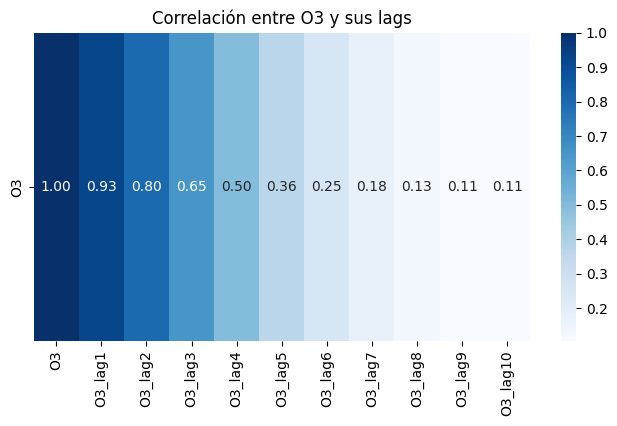

In [40]:
# 4) Correlación de cada lag con la variable original (descartando NaN por lags)
lags_cols = [c for c in df.columns if c.startswith('O3_lag')]
corr = df[['O3'] + lags_cols].dropna().corr()['O3'].sort_values(ascending=False)
corr

# 5) Mapa de calor de correlaciones (Nivel vs. sus lags)
plt.figure(figsize=(8, 4))
sns.heatmap(
    df[['O3'] + lags_cols].dropna().corr()[['O3']].T,
    annot=True, cmap='Blues', fmt=".2f"
)
plt.title('Correlación entre O3 y sus lags')
plt.show()

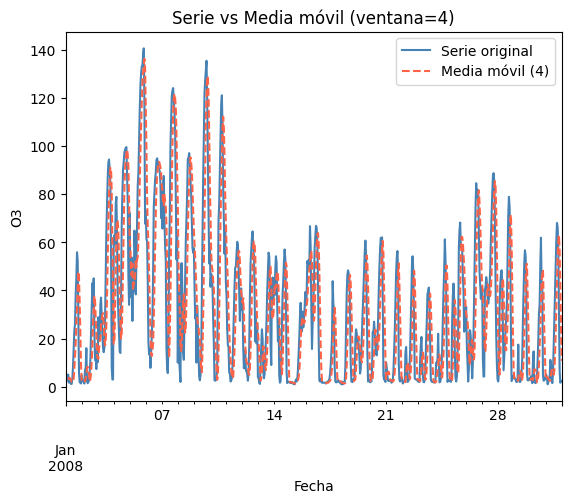

In [41]:
# === Bloque 6: Ventanas deslizantes (rolling) — versión simple ===

df_rolling = df.copy()
columna = 'O3'   # cambia si tu variable principal tiene otro nombre

# 1) Media móvil (ventana 4), desplazando 1 paso para no usar el valor actual
df_rolling['media_movil_4'] = df_rolling[columna].shift(1).rolling(window=4).mean()

# 2) Otras estadísticas con la misma ventana
df_rolling['max_movil_4'] = df_rolling[columna].shift(1).rolling(window=4).max()
df_rolling['min_movil_4'] = df_rolling[columna].shift(1).rolling(window=4).min()
df_rolling['std_movil_4'] = df_rolling[columna].shift(1).rolling(window=4).std()

# 3) Vista rápida
df_rolling[[columna, 'media_movil_4', 'max_movil_4', 'min_movil_4', 'std_movil_4']].head(10)

# 4) Comparación visual: serie original vs media móvil (4)
ax = df_rolling[columna].plot(label='Serie original', color='steelblue')
df_rolling['media_movil_4'].plot(ax=ax, label='Media móvil (4)', color='tomato', linestyle='--')
ax.set_title('Serie vs Media móvil (ventana=4)')
ax.set_xlabel('Fecha'); ax.set_ylabel(columna)
ax.legend(); plt.show()

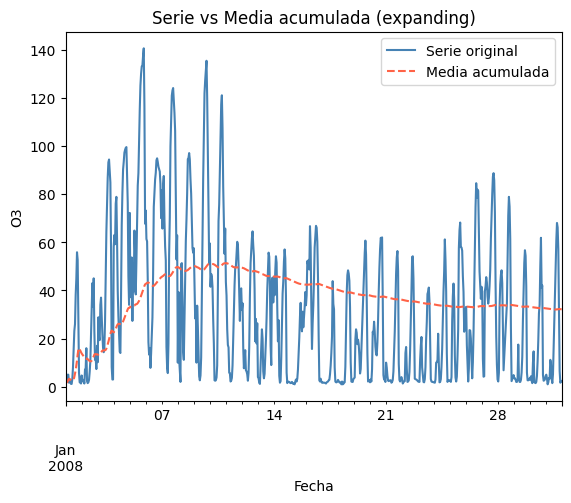

In [43]:
# === Bloque 7: Ventanas ampliadas (expanding) — versión simple ===
import matplotlib.pyplot as plt

columna = 'O3'   # cambia si tu variable principal tiene otro nombre

# 1) Estadísticas acumuladas (memoria creciente) con shift(1)
df_rolling['media_acum'] = df_rolling[columna].shift(1).expanding().mean()
df_rolling['suma_acum']  = df_rolling[columna].shift(1).expanding().sum()
df_rolling['max_acum']   = df_rolling[columna].shift(1).expanding().max()
df_rolling['std_acum']   = df_rolling[columna].shift(1).expanding().std()

# 2) Extra robusto: mínimo acumulado y, si está disponible, cuartil 25% acumulado
df_rolling['min_acum']   = df_rolling[columna].shift(1).expanding().min()
try:
    df_rolling['q25_acum'] = df_rolling[columna].shift(1).expanding().quantile(0.25)
except Exception as e:
    # Algunas versiones de pandas no soportan quantile en expanding
    print('Cuartil acumulado no soportado en esta versión de pandas:', e)

# 3) Vista rápida
df_rolling[[columna, 'media_acum', 'suma_acum', 'max_acum', 'std_acum', 'min_acum']].head(10)

# 4) Comparación visual: serie original vs media acumulada
ax = df_rolling[columna].plot(label='Serie original', color='steelblue')
df_rolling['media_acum'].plot(ax=ax, label='Media acumulada', color='tomato', linestyle='--')
ax.set_title('Serie vs Media acumulada (expanding)')
ax.set_xlabel('Fecha'); ax.set_ylabel(columna)
ax.legend(); plt.show()


In [44]:
df_rolling

,O3,O3_lag1,O3_lag2,O3_lag3,O3_lag4,O3_lag5,O3_lag6,O3_lag7,O3_lag8,O3_lag9,...,media_movil_4,max_movil_4,min_movil_4,std_movil_4,media_acum,suma_acum,max_acum,std_acum,min_acum,q25_acum
datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-01 00:00:00,1.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 01:00:00,2.0000,1.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.666700,1.66670,1.6667,NaN,1.6667,1.666700
2008-01-01 02:00:00,2.8333,2.0000,1.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.833350,3.66670,2.0000,0.235679,1.6667,1.750025
2008-01-01 03:00:00,5.0000,2.8333,2.0000,1.6667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.166667,6.50000,2.8333,0.600893,1.6667,1.833350
2008-01-01 04:00:00,5.0000,5.0000,2.8333,2.0000,1.6667,NaN,NaN,NaN,NaN,NaN,...,2.875000,5.0000,1.6667,1.499220,2.875000,11.50000,5.0000,1.499220,1.6667,1.916675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-01-31 19:00:00,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,5.1667,...,62.958350,68.0000,57.0000,5.048608,32.251849,23834.11615,140.5000,31.372923,1.0000,3.833300
2008-01-31 20:00:00,6.5000,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,16.3333,...,55.958350,68.0000,32.6667,16.256258,32.252409,23866.78285,140.5000,31.351693,1.0000,3.833300
2008-01-31 21:00:00,1.6667,6.5000,32.6667,57.0000,66.1667,68.0000,60.6667,49.0000,38.5000,27.0000,...,40.583350,66.1667,6.5000,26.760433,32.217656,23873.28285,140.5000,31.344782,1.0000,3.833300


Rendimiento medio (TimeSeriesSplit, R^2): 0.730


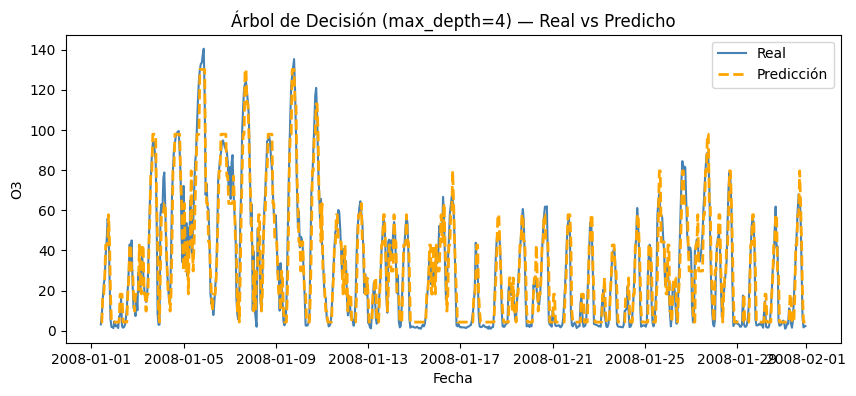

In [ ]:
# === Bloque 8: Integración y prueba de modelado (versión simple) ===
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score  # (opcional) TimeSeriesSplit ver abajo
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit

# 1) Selección de atributos (usa exactamente los que ya has creado)
atributos = [
    'O3_lag1','O3_lag2','O3_lag3','O3_lag4','O3_lag5','O3_lag6','O3_lag7','O3_lag8','O3_lag9','O3_lag10',
    'media_movil_4','max_movil_4','min_movil_4','std_movil_4',
    'media_acum','suma_acum','max_acum','std_acum'
]

X = df_rolling[atributos]
y = df_rolling['O3']

# 2) Eliminar filas con NaN (por lags/ventanas) y alinear índices
X = X.dropna()
y = y.loc[X.index]

# 3) Modelo base (árbol poco profundo para evitar sobreajuste)
model = DecisionTreeRegressor(max_depth=4, random_state=42)

# 4) Para series, mejor TimeSeriesSplit (ver comentario)
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model, X, y, cv=tscv)
print(f"Rendimiento medio (TimeSeriesSplit, R^2): {scores.mean():.3f}")

#scores = cross_val_score(model, X, y, cv=5)
#print(f"Rendimiento medio (CV=5, R^2): {scores.mean():.3f}")

# 5) Entrenar en todo el conjunto y predecir (solo para visualizar el pipeline)
model.fit(X, y)
y_pred = model.predict(X)

# 6) Visualización: real vs predicho
plt.figure(figsize=(10,4))
plt.plot(y.index, y, label='Real', color='steelblue')
plt.plot(y.index, y_pred, label='Predicción', color='orange', linestyle='--', linewidth=2)
plt.title('Árbol de Decisión (max_depth=4) — Real vs Predicho')
plt.xlabel('Fecha'); plt.ylabel('O3'); plt.legend()
plt.show()

